In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
import finite_lec as finite
import timesteppers_lec as timesteppers 
import time
from IPython.display import display, clear_output

First we'll try to use Forward Euler to solve the diffusion equation
$$\partial_t u = \partial_x^2 u.$$
Recall that this equation has the solution
$$u \sim t^{-1/2}\exp(-x^2/(4t)).$$

initializing the t=1. And evolve for 1 time unite 

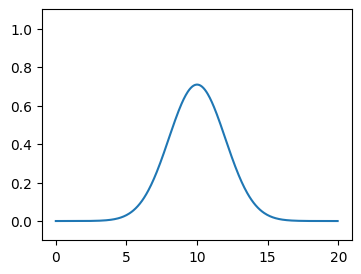

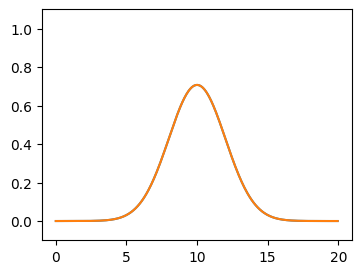

In [ ]:
res = 400 # resolution 
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4) # initial condition, -10 is shift to center 

target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

# Calculate the right hand side. 
d2 = finite.CenteredFiniteSecondDifference(grid) # matrix. 
f = lambda u: d2 @ u

# Use Forward Euler, we need to pass the initial condition and function calculate the right hand side 
alpha = 0.45
ts = timesteppers.ForwardEuler(IC, f)

dt = alpha*grid.dx**2
output_cadence = 10

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 1:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
p.set_ydata(ts.u)
plt.plot(x, target)

0.018000000000000006


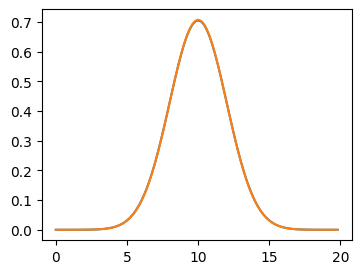

In [7]:
res = 100
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4)
target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

d2 = finite.CenteredFiniteSecondDifference(grid)
f = lambda u: d2 @ u

alpha = 0.45
ts = timesteppers.ForwardEuler(IC, f)

dt = alpha*grid.dx**2

ts.evolve(dt, 1)
print(dt)

plt.figure(figsize=(4,3))
plt.plot(x, ts.u)
plt.plot(x, target)

## Backward Euler

The Backward Euler method is
$$u^{n} = u^{n-1} + \Delta t L(u^n).$$
We can think of this as
$$(I - \Delta t L)u^{n} = u^{n-1}.$$
We will solve for $u^{n}$ using a sparse matrix solve.

In [ ]:
class ImplicitTimestepper(timesteppers.Timestepper):

    def __init__(self, u, L):
        super().__init__()
        self.u = u
        self.L = L
        N = len(u)
        self.I = sparse.eye(N, N) #identify    

In [ ]:
class BackwardEuler(ImplicitTimestepper):

    def _step(self, dt):
        u^{n-1} = self.u 
        # u^{n} = (I-dt*self.L)^-1 @ u^{n-1}
        if dt != self.dt: # check the step is same as the last step 
            self.LHS = self.I - dt*self.L.matrix # store the previous time steps 
#            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
#        return self.LU.solve(self.u)
        return spla.spsolve(self.LHS, self.u)

We can use this to solve the diffusion equation
$$ \partial_t u = \partial_x^2 u,$$
using $L=\partial_x^2$.

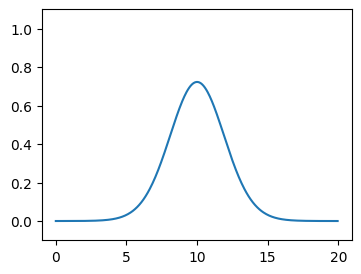

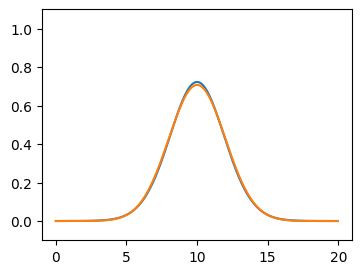

In [ ]:
# Backward euler for diffusion equation  
res = 400
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4)
target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

d2 = finite.CenteredFiniteSecondDifference(grid)

alpha = 5
ts = BackwardEuler(IC, d2)

dt = alpha*grid.dx
print(dt)

output_cadence = 1

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 1:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
        time.sleep(0.3)
p.set_ydata(ts.u)
plt.plot(x, target)

0.05


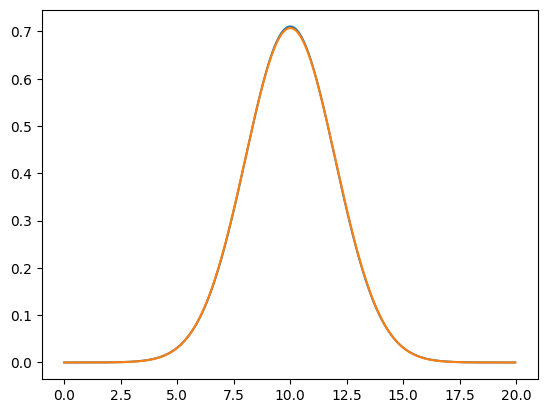

In [12]:
res = 400
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4)
target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

d2 = finite.CenteredFiniteSecondDifference(grid)

alpha = 1
ts = BackwardEuler(IC, d2)

dt = alpha*grid.dx

ts.evolve(dt, 1)
print(dt)

plt.figure()
plt.plot(x, ts.u)
plt.plot(x, target)

As well as the wave equation
$$ \partial_t u = \partial_x u,$$
using $L=\partial_x$.

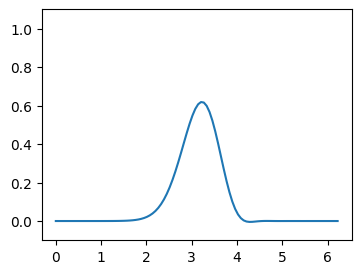

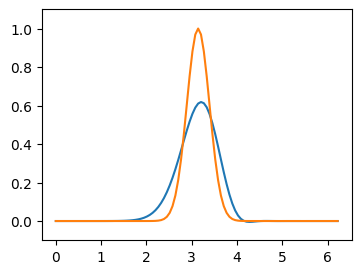

In [13]:
res = 100
grid = finite.UniformPeriodicGrid(res, 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)
target = np.exp(-(x-np.pi)**2*8)

d = finite.CenteredFiniteDifference(grid)

alpha = 1/4.
ts = BackwardEuler(IC, d)

dt = alpha*grid.dx
print(dt)

output_cadence = 10

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
p.set_ydata(ts.u)
plt.plot(x, target)

0.015707963267948967


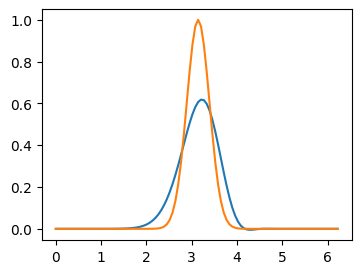

In [14]:
res = 100
grid = finite.UniformPeriodicGrid(res, 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)
target = np.exp(-(x-np.pi)**2*8)

d = finite.CenteredFiniteDifference(grid)

alpha = 1/4.
ts = BackwardEuler(IC, d)

dt = alpha*grid.dx

num_periods = 1
ts.evolve(dt, 2*np.pi*num_periods)
print(dt)

plt.figure(figsize=(4,3))
plt.plot(x, ts.u)
plt.plot(x, target)

How does the matrix solve work? One way is using the LU factorization. We are trying to solve
$$ A\cdot x = b$$
for $x$. We can write
$$ A = L \cdot U$$
where $L$ is a lower-triangular matrix, and $U$ is an upper-triangular matrix.

In [15]:
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

In [16]:
N = 20
grid = finite.UniformPeriodicGrid(N, 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)

d = finite.CenteredFiniteDifference4(grid)

alpha = 0.05
ts = BackwardEuler(IC, d)
ts.step(0.01)

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_23207/3554179220.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


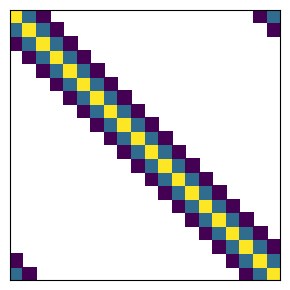

In [17]:
plot_2D(ts.LHS.toarray())

In [18]:
LU = spla.splu(ts.LHS.tocsc(), permc_spec='NATURAL')
np.allclose((LU.L @ LU.U).toarray(), ts.LHS.toarray())

True

Once doing this factorization, we solve
$$ U \cdot y = b$$
and then
$$ L \cdot x = y.$$

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_23207/3554179220.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


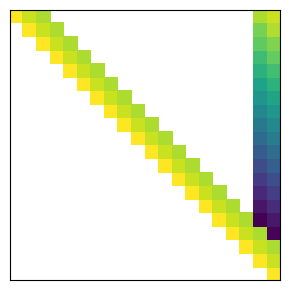

In [19]:
plot_2D(LU.U.toarray())

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_23207/3554179220.py:6: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


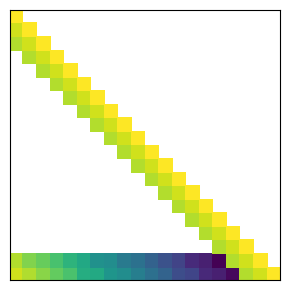

In [20]:
plot_2D(LU.L.toarray())